In [0]:
!pip install patool

     |████████████████████████████████| 81kB 2.5MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import patoolib
patoolib.extract_archive("drive/My Drive/predict_future_sales.zip",outdir="sample_data")

patool: Extracting drive/My Drive/predict_future_sales.zip ...
patool: running /usr/bin/7z x -osample_data -- "drive/My Drive/predict_future_sales.zip"
patool: ... drive/My Drive/predict_future_sales.zip extracted to `sample_data'.


'sample_data'

# **Importing libraries**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Reading raw dataset**

In [0]:
train = pd.read_csv('sample_data/sales_train.csv')
cats = pd.read_csv('sample_data/item_categories.csv')
items = pd.read_csv('sample_data/items.csv')
shops = pd.read_csv('sample_data/shops.csv')
#sample_submission = pd.read_csv('sample_data/sample_submission.csv')
test = pd.read_csv('sample_data/test.csv')

# **EDA of raw data**

In [0]:
df=train.merge(items,on='item_id',how='left')
df=df.merge(cats,on='item_category_id',how='left')
df=df.merge(shops,on='shop_id',how='left')


Text(0.5, 1.0, 'daly sale of items')

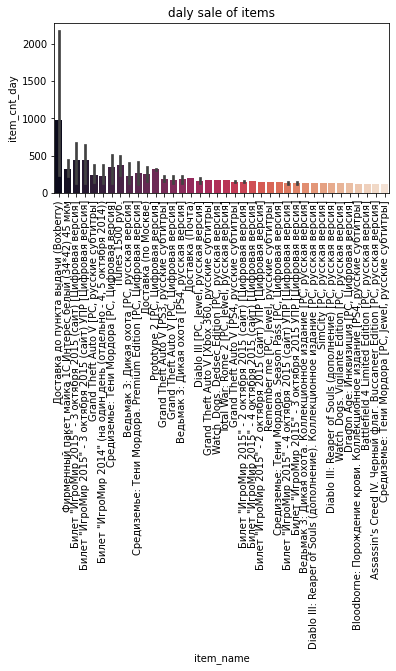

In [0]:
d=df[['item_cnt_day', 'item_name','item_price','shop_name','item_category_name']].sort_values('item_cnt_day', ascending=False).head(100)
plt.xticks( rotation=90)
plt.subplots_adjust(bottom=0.4,top=0.99)
sns.barplot(x='item_name', y="item_cnt_day", data=d,  palette="rocket").set_title("daly sale of items")


* The above plot show the daily sale of items. Its clear from the graph that a few product have high sale. This plot shows the top 100 days sales  .












Text(0.5, 1.0, 'daily sale of shop')

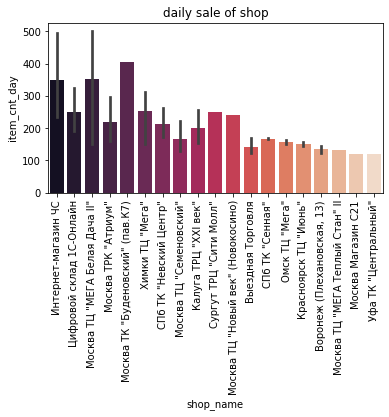

In [0]:
plt.xticks( rotation=90)
plt.subplots_adjust(bottom=0.4,top=0.99)
sns.barplot(x=d.shop_name, y=d["item_cnt_day"], data=d,  palette="rocket").set_title("daily sale of shop")


* the above plot show the daily sale of shop by considering top 100 days sales. Most of the shops have similar sales except 3 which has much higher sale than others.  

Text(0.5, 1.0, 'daily sale of item category')

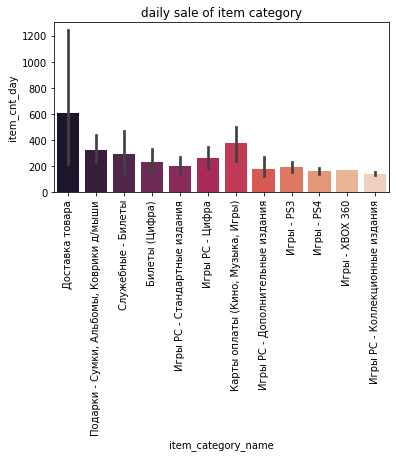

In [0]:
plt.xticks( rotation=90)
plt.subplots_adjust(bottom=0.4,top=0.99)
sns.barplot(x=d.item_category_name, y=d["item_cnt_day"], data=d,  palette="rocket").set_title("daily sale of item category")


* The above plot shows the sale of item category by considering top 100 days sales.It is clear from the plot that a perticular category has higher demand than other.

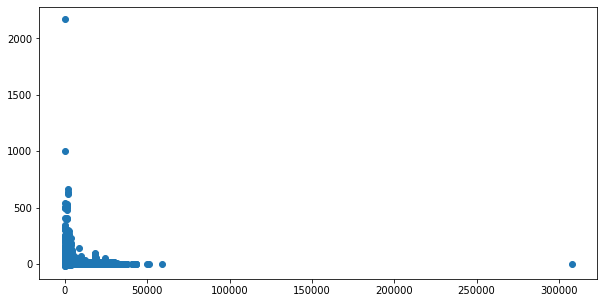

In [0]:
plt.figure(figsize=(10, 5))
plt.scatter(train['item_price'], train['item_cnt_day'])
plt.show()

* Its clear from the plot that most of the daily sale contains a very few number of products i.e nearly one.

In [0]:
summ = train.groupby(['shop_id'], as_index=False)[['item_cnt_day']].sum()
mean = train.groupby(['shop_id'], as_index=False)[['item_cnt_day']].mean()
summ = summ.rename(columns={'item_cnt_day': 'item_cnt_sum'}).sort_values(by='item_cnt_sum')
mean = mean.rename(columns={'item_cnt_day': 'item_cnt_mean'})




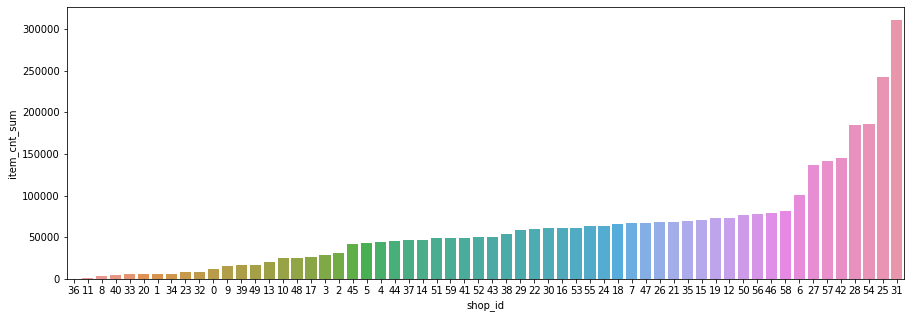

In [0]:
f, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(x=summ['shop_id'], y=summ['item_cnt_sum'],  order=shop_sum['shop_id'])

* From the above plot its clear that very few shop has high 

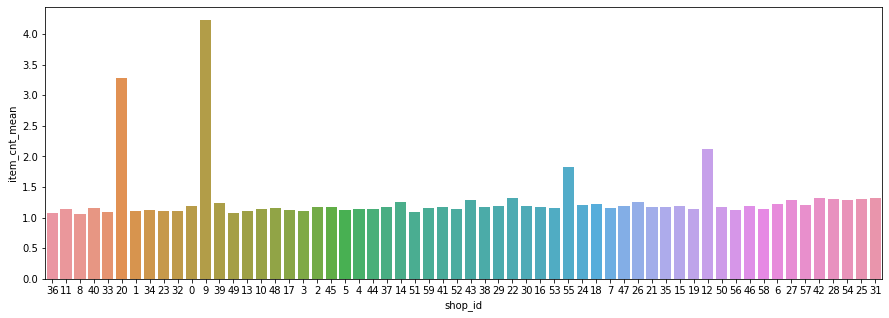

In [0]:
f, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot(x=mean['shop_id'], y=mean['item_cnt_mean'], order=shop_sum['shop_id'])
plt.show()

* The average sale of most of the shops is around one. 

In [0]:
df=pd.merge(train,items,on=['item_id'])


In [0]:
summ = df.groupby(['item_category_id'], as_index=False)[['item_cnt_day']].sum()
mean = df.groupby(['item_category_id'], as_index=False)[['item_cnt_day']].mean()
summ = summ.rename(columns={'item_cnt_day': 'item_cnt_sum'}).sort_values(by='item_cnt_sum')
                                   
mean =mean.rename(columns={'item_cnt_day': 'item_cnt_mean'})
                                     



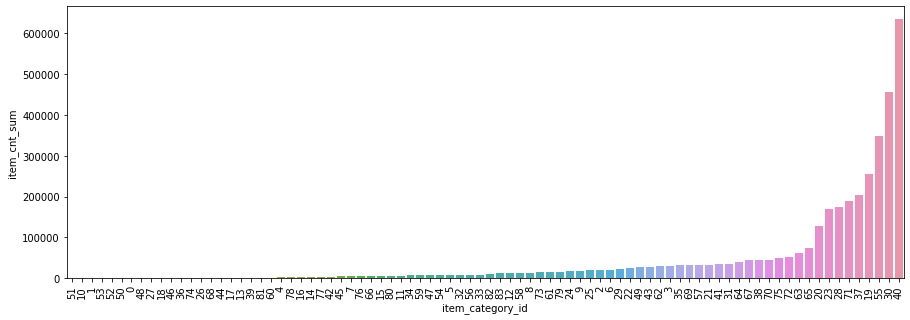

In [0]:
f, axes = plt.subplots(1, 1, figsize=(15, 5), sharex=False)
plt.xticks(rotation=90)
sns.barplot(x=summ['item_category_id'], y=summ['item_cnt_sum'], order=summ['item_category_id'])   
plt.show()

* Only four category of products have very high sale

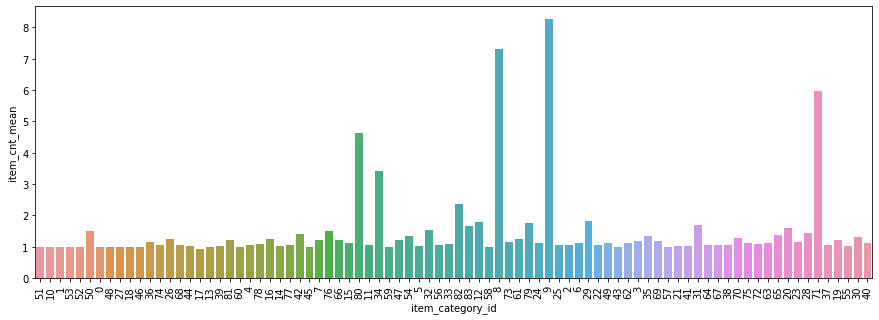

In [0]:
f, axes = plt.subplots(1, 1, figsize=(15, 5), sharex=False)
plt.xticks(rotation=90)
sns.barplot(x=mean['item_category_id'], y=mean['item_cnt_mean'],order=summ['item_category_id'])
            

* Maximum categories of items have mean sale one per day.

Text(0.5, 1.0, 'Box plot of items price')

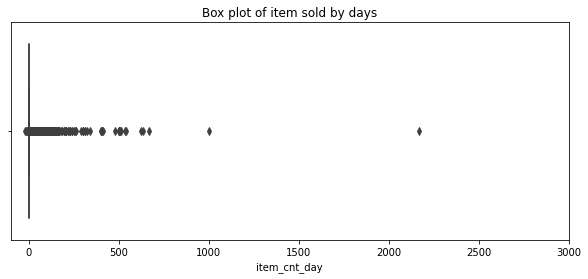

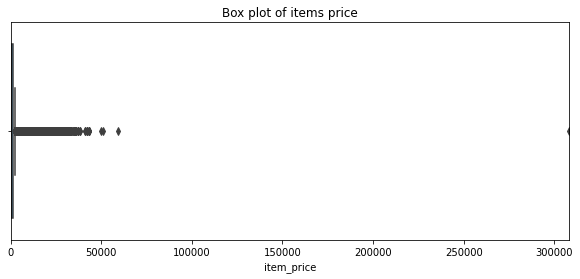

In [0]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)
plt.title('Box plot of item sold by days' )

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max())
sns.boxplot(x=train.item_price)
plt.title('Box plot of items price' )

* Its clear from the plot of item price and item_cnt_day that there are some outliers in the dataset which should be removed for better performance of models

# Observation

After doing the EDA its clear that there are few categories  dominating the daily sale.

The sale of some shops are very high.

Data contains some outliers .



# Data cleaning 

In [0]:
""" removing outliers """
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1000]

In [0]:
""" replacing negative values with zero """
train = train[train.item_price > 0].reset_index(drop = True)
train=train.replace({'item_cnt_day':-1},0)


In [0]:
""" removing duplicate shop_id from test and train dataset"""
train=train.replace({'shop_id':0},57)
test=test.replace({'shop_id':0},57)
train=train.replace({'shop_id':1},58)
test=test.replace({'shop_id':1},58)
train=train.replace({'shop_id':11},10)
test=test.replace({'shop_id':11},10)
train=train.replace({'shop_id':40},39)
test=test.replace({'shop_id':40},39)


# Feature engineering

In [0]:
""" splitting shop name by space to get the city code and shop category """
shops=shops.replace({'shop_name':'Сергиев Посад ТЦ "7Я"'},'СергиевПосад ТЦ "7Я"')
df=[]
df_1=[]
for name in shops.shop_name:
  x=name.split(" ")
  df.append(x[0])
  df_1.append(x[1])
shops["city"] = df
shops["category"]=df_1
shops=shops.replace({'city':"!Якутск"},"Якутск")

In [0]:
""" replacing categories  with count less than 4 with etc """
df=shops.groupby('category').count()
df.reset_index(inplace=True)
z=df.shop_id
for i,cat in enumerate(df.category):
    if z[i] < 4:
        shops=shops.replace({'category':cat},'etc')

In [0]:
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )

In [0]:
shops.drop(["shop_name","city","category"],axis=1,inplace=True)

In [0]:
shops.head()

,shop_id,shop_category,shop_city
0,0,0,29
1,1,4,29
2,2,4,0
3,3,2,1
4,4,4,2


In [0]:
""" splitting item_category_name by sapce to get the type code  """
df=[]
for name in cats.item_category_name:
  x=name.split(" ")
  df.append(x[0])

cats["type_code"]=df 
cats['category']=np.where(cats['type_code'] == "Игровые",['Игры'],np.nan)
cats['category']=np.where(cats['type_code'] == "Аксессуары",['Игры'],np.nan)


In [0]:
""" replacing categories  with count less than 4 with etc  """
df=cats.groupby('category').count()
df.reset_index(inplace=True)
z=df.item_category_id
for i,cod in enumerate(df.type_code):
    if z[i] < 4:
        cats=cats.replace({'type_code':cod},'etc')
cats.type_code = LabelEncoder().fit_transform(cats.type_code)

In [0]:
""" spliting item_category_name with '-'  """
df=[]
for name in cats.item_category_name:
  x=name.split("-")
  df.append(x)
cats["split"]=df


In [0]:
""" getting the subtype code from split """
df=[]
for name in cats.split:
  if len(name) > 1:
    df.append(name[1].strip())
  else:
    df.append(name[0].strip())

cats["subtype"]=df 
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats.drop(['item_category_name','category','split','subtype'],axis=1,inplace=True)


In [0]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [0]:
""""  spiting items name to get name1"""
#df=[]
df_1=[]
for name in items.item_name:
  x=name.split("[",1)
  #df.append(x[0])
  try:
    df_1.append(x[1])
  except:
    df_1.append(np.nan)

#items['name1']=df
items['name1']=df_1

In [0]:
"""  replacing patern and converting every thing to lower case """
items = items.fillna('0')
items["name1"] = items.name1.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
#items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

In [0]:
"""  label encoding name1"""
items.name1 = LabelEncoder().fit_transform(items.name1)
#items.name2 = LabelEncoder().fit_transform(items.name2)
items.drop(["item_name"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name1
0,0,40,4
1,1,76,64
2,2,40,4
3,3,40,4
4,4,40,4


In [0]:
""" creating dataset like the test dataset   """
dataset = []
for i in range(34):
    temp = train[train.date_block_num == i]
    for j in temp.shop_id.unique():
        for k in temp.item_id.unique():
            dataset.append([i, j, k])
    
dataset = pd.DataFrame(dataset, columns=['date_block_num','shop_id','item_id'])
dataset["date_block_num"] = dataset["date_block_num"].astype(np.int8)
dataset["shop_id"] = dataset["shop_id"].astype(np.int8)
dataset["item_id"] = dataset["item_id"].astype(np.int16)

In [0]:
"""  calculating the total sale of an item in a shop over a month"""
temp = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
temp.columns = ["item_cnt_month"]
temp.reset_index( inplace = True)
dataset = pd.merge( dataset, temp, on = ['date_block_num','shop_id','item_id'], how = "left" )
dataset["item_cnt_month"] = dataset["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16)

In [0]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [0]:
dataset = pd.concat([dataset, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
dataset.fillna( 0, inplace = True )

In [0]:
dataset = pd.merge(dataset, items, on = ["item_id"], how = "left")
dataset = pd.merge( dataset, shops, on = ["shop_id"], how = "left" )
dataset = pd.merge( dataset, cats, on = ["item_category_id"], how = "left" )


In [0]:

dataset["item_category_id"] = dataset["item_category_id"].astype(np.int8)
dataset["shop_city"] = dataset["shop_city"].astype(np.int8)
dataset["subtype_code"] = dataset["subtype_code"].astype(np.int8)
dataset["shop_category"] = dataset["shop_category"].astype(np.int8)
dataset["type_code"] = dataset["type_code"].astype(np.int8)

In [0]:
""" calculating the total number of unique items a shop have  """
temp=dataset.groupby(["date_block_num","shop_id"]).agg({"item_id" : pd.Series.nunique})
temp.columns=['unique_item_cnt']
temp.reset_index(inplace=True)

dataset = pd.merge(dataset, temp, on = ["date_block_num","shop_id"], how = "left")
dataset['unique_item_cnt'] = dataset["unique_item_cnt"].astype(np.float16)


In [0]:
#temp=dataset.groupby(["date_block_num","shop_id"]).agg({"item_category_id" : pd.Series.nunique})
#temp.columns=['unique_item_cat_cnt']
#temp.reset_index(inplace=True)

#dataset = pd.merge(dataset, temp, on = ["date_block_num","shop_id"], how = "left")
#dataset['unique_item_cat_cnt'] = dataset["unique_item_cat_cnt"].astype(np.float16)

In [0]:
"""      
this function takes three parameters dataset no. of lags i.e no. of pevious months to include and the column 
of which previous months is to be included. considering the date_block_num, shop_id,item_id and the
column  for each lag creating a dataframe with features date_block_num, shop_id, item_id and
col + "_lag_"+str(i) after that making  date_block_num of new dataframe to date_block_num + lag no. and merging 
it with the original dataframe .  



"""
def lag_( df,lags, col ):
    tmp = df[["date_block_num", "shop_id","item_id",col ]]
    for i in lags:
        df_1 = tmp.copy()
        df_1.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
        df_1.date_block_num = df_1.date_block_num + i
        df = pd.merge(df, df_1, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [0]:
#temp=dataset.groupby(["date_block_num","shop_id","item_category_id"]).agg({"item_cnt_month" : ["mean"]})
#temp.columns=["date_shop_cat_avg_item_cnt"]
#temp.reset_index(inplace=True)
#dataset=pd.merge(dataset,temp,on=["date_block_num","shop_id","item_category_id"],how='left')
#dataset['date_shop_cat_avg_item_cnt']=dataset["date_shop_cat_avg_item_cnt"].astype(np.float16)



In [0]:
"""  creating lag features of sale of a month """
dataset = lag_( dataset, [1,2,3], "item_cnt_month" )

In [0]:
"""  computing the average sale of a month """
temp = dataset.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
temp.columns = ["date_avg_item_cnt"]
temp.reset_index(inplace = True)
dataset = pd.merge(dataset,temp, on = ["date_block_num"], how = "left")
dataset['date_avg_item_cnt'] = dataset["date_avg_item_cnt"].astype(np.float16)


In [0]:
"""  computing the average sale of an item over a month"""
temp = dataset.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
temp.columns = [ 'date_item_avg_item_cnt' ]
temp.reset_index(inplace=True)
dataset = pd.merge(dataset, temp, on=['date_block_num','item_id'], how='left')
dataset['date_item_avg_item_cnt'] = dataset['date_item_avg_item_cnt'].astype(np.float16)


In [0]:
"""    computing the average sale of an item in a shop for a month""" 
temp = dataset.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
temp.columns = ["date_shop_item_avg_item_cnt"]
temp.reset_index(inplace = True)
dataset = pd.merge(dataset,temp, on = ["date_block_num","shop_id","item_id"], how = "left")
dataset['date_avg_item_cnt'] = dataset["date_shop_item_avg_item_cnt"].astype(np.float16)


In [0]:
"""  computing the average sale of a shop for a month """
temp = dataset.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
temp.columns = ["date_shop_avg_item_cnt"]
temp.reset_index(inplace = True)
dataset = pd.merge(dataset, temp, on = ["date_block_num","shop_id"], how = "left")
dataset['date_avg_item_cnt'] = dataset["date_shop_avg_item_cnt"].astype(np.float16)


In [0]:
"""   computing the average sale of a subcategory in a shop for a month  """

temp = dataset.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_subtype_avg_item_cnt']
temp.reset_index(inplace=True)
dataset = pd.merge(dataset, temp, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
dataset['date_shop_subtype_avg_item_cnt'] = dataset['date_shop_subtype_avg_item_cnt'].astype(np.float16)


In [0]:
"""   computing the average sale of a city over a month """

temp = dataset.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_city_avg_item_cnt']
temp.reset_index(inplace=True)

dataset = pd.merge(dataset, temp, on=['date_block_num', "shop_city"], how='left')
dataset['date_city_avg_item_cnt'] = dataset['date_city_avg_item_cnt'].astype(np.float16)


In [0]:
"""  computing the average sale of an item in a city for a month """
temp = dataset.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
temp.columns = [ 'date_item_city_avg_item_cnt' ]
temp.reset_index(inplace=True)
dataset = pd.merge(dataset, temp, on=['date_block_num', 'item_id', 'shop_city'], how='left')
dataset['date_item_city_avg_item_cnt'] = dataset['date_item_city_avg_item_cnt'].astype(np.float16)


In [0]:
""" genrating lag features  """

dataset = lag_(dataset, [1], 'date_item_city_avg_item_cnt')
dataset.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
dataset = lag_(dataset, [1], 'date_city_avg_item_cnt')
dataset.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
dataset = lag_(dataset, [1], 'date_shop_subtype_avg_item_cnt')
dataset.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
dataset = lag_( dataset, [1,2,3], "date_shop_item_avg_item_cnt" )
dataset.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
dataset = lag_( dataset, [1,2,3], "date_shop_avg_item_cnt" )
dataset.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
dataset = lag_(dataset, [1,2,3], 'date_item_avg_item_cnt')
dataset.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
dataset = lag_( dataset, [1], "date_avg_item_cnt" )
dataset.drop( ['date_avg_item_cnt'], axis = 1, inplace = True )
#dataset = lag_(dataset, [1], 'date_shop_cat_avg_item_cnt')
#dataset.drop(['date_shop_cat_avg_item_cnt'],axis=1,inplace=True)

In [0]:
"""  calculating the total average price of an item  """

temp = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
temp.columns = ["item_avg_item_price"]
temp.reset_index(inplace = True)

dataset = dataset.merge( temp, on = ["item_id"], how = "left" )
dataset["item_avg_item_price"] = dataset['item_avg_item_price'].astype(np.float16)


In [0]:
"""  claculating the average price of an item over a month   """
temp = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
temp.columns = ["date_item_avg_item_price"]
temp.reset_index(inplace = True)

dataset = dataset.merge(temp, on = ["date_block_num","item_id"], how = "left")
dataset["date_item_avg_item_price"] = dataset["date_item_avg_item_price"].astype(np.float16)



In [0]:
"""  claculating the change in items price """

lags = [1,2,3]
dataset = lag_(dataset, lags, 'date_item_avg_item_price')

for i in lags:
    dataset['delta_price_lag_'+str(i)] = (dataset['date_item_avg_item_price_lag_'+str(i)] - dataset['item_avg_item_price']) / dataset['item_avg_item_price']

""" this function returns the lag feature values in sequence """        
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

dataset['delta_price_lag'] = dataset.apply(select_trend, axis=1)
dataset['delta_price_lag'] = dataset['delta_price_lag'].astype(np.float16)
dataset['delta_price_lag'].fillna(0, inplace=True)

In [0]:
dataset.drop(['item_avg_item_price','date_item_avg_item_price','date_item_avg_item_price_lag_1','date_item_avg_item_price_lag_2','date_item_avg_item_price_lag_3','delta_price_lag_1','delta_price_lag_2','delta_price_lag_3'],axis=1,inplace=True)

In [0]:
"""   calculating the  change in revenue for each shop     """

train["revenue"] = train["item_cnt_day"] * train["item_price"]
temp = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
temp.columns = ["date_shop_revenue"]
temp.reset_index(inplace = True)

dataset = dataset.merge( temp , on = ["date_block_num", "shop_id"], how = "left" )
dataset['date_shop_revenue'] = dataset['date_shop_revenue'].astype(np.float32)

temp = dataset.groupby(["shop_id"]).agg({ "date_shop_revenue":["mean"] })
temp.columns = ["shop_avg_revenue"]
temp.reset_index(inplace = True )

dataset = dataset.merge( temp, on = ["shop_id"], how = "left" )
dataset["shop_avg_revenue"] = dataset['shop_avg_revenue'].astype(np.float32)
dataset["delta_revenue"] = (dataset['date_shop_revenue'] - dataset['shop_avg_revenue']) / dataset['shop_avg_revenue']
dataset["delta_revenue"] = dataset["delta_revenue"]. astype(np.float32)

dataset = lag_(dataset, [1], "delta_revenue")
dataset["delta_revenue_lag_1"] = dataset["delta_revenue_lag_1"].astype(np.float32)

dataset.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

In [0]:
"""  determining the  month number  """
dataset["month"] = dataset["date_block_num"] % 12

In [0]:
dataset["item_shop_first_sale"] = dataset["date_block_num"] - dataset.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
dataset["item_first_sale"] = dataset["date_block_num"] - dataset.groupby(["item_id"])["date_block_num"].transform('min')

In [0]:
""" finding whether a day is holiday or not """
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dr = pd.date_range(start='01-01-2013', end='30-11-2015')
df = pd.DataFrame()
df['date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df['Holiday'] = df['date'].isin(holidays)
print (df)

           date  Holiday
0    2013-01-01     True
1    2013-01-02    False
2    2013-01-03    False
3    2013-01-04    False
4    2013-01-05    False
...         ...      ...
1059 2015-11-26     True
1060 2015-11-27    False
1061 2015-11-28    False
1062 2015-11-29    False
1063 2015-11-30    False

[1064 rows x 2 columns]


In [0]:
 df['Holiday']=LabelEncoder().fit_transform( df.Holiday )

In [0]:
df=df.groupby(df['date'].dt.strftime('%m,%y'))['Holiday'].sum()
d=df.reset_index()


In [0]:
""" creating a list to store the  date_block_num according to the hoidays  """

a=[]
for i in range (12):
  
  a.append(i)
  a.append(i+12)
  if (i+24)<35:
    a.append(i+24)
a=np.asarray(a)
a=a.reshape(-1,1)

In [0]:
d['date_block_num']=a
d.drop(['date'],axis=1,inplace=True)
d.head()

,Holiday,date_block_num
0,2,0
1,2,12
2,2,24
3,1,1
4,1,13


In [0]:

dataset = dataset.merge( d , on = ["date_block_num"], how = "left" )

In [0]:
""" using days as a feature  """
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
dataset["days"] = dataset["month"].map(days).astype(np.int8)

In [0]:
dataset

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,name1,shop_category,shop_city,type_code,subtype_code,unique_item_cnt,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_item_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,item_shop_first_sale,item_first_sale,Holiday,days
0,0,59,22154,1.0,37,4,4,30,7,1,8116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,0,0,2,31
1,0,59,2552,0.0,58,4,4,30,9,27,8116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,0,0,2,31
2,0,59,2554,0.0,58,4,4,30,9,27,8116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,0,0,2,31
3,0,59,2555,0.0,56,4,4,30,9,3,8116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,0,0,2,31
4,0,59,2564,0.0,59,4,4,30,9,40,8116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0,0,0,2,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,34,45,18454,0.0,55,4,4,20,9,2,5100.0,1.0,0.0,0.0,0.5,0.135376,0.126831,1.0,0.0,0.0,0.126709,0.129395,0.13916,0.045441,0.023254,0.071411,0.126709,-0.475098,-0.312544,10,11,11,2,30
11056273,34,45,16188,0.0,64,4,4,20,10,42,5100.0,0.0,0.0,NaN,0.0,0.135376,0.094482,0.0,0.0,NaN,0.126709,0.129395,NaN,0.022720,0.069763,NaN,0.126709,0.081116,-0.312544,10,2,2,2,30
11056274,34,45,15757,0.0,55,4,4,20,9,2,5100.0,0.0,0.0,0.0,0.0,0.135376,0.126831,0.0,0.0,0.0,0.126709,0.129395,0.13916,0.113647,0.069763,0.095215,0.126709,0.155884,-0.312544,10,34,34,2,30
11056275,34,45,19648,0.0,40,4,4,20,7,4,5100.0,0.0,0.0,0.0,0.0,0.135376,0.083740,0.0,0.0,0.0,0.126709,0.129395,0.13916,0.045441,0.069763,0.166626,0.126709,-0.091736,-0.312544,10,11,11,2,30


# Train Test split

In [0]:
dataset.fillna(0,inplace=True)
dataset = dataset[dataset["date_block_num"] > 3]

In [0]:
X_train = dataset[dataset.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = dataset[dataset.date_block_num < 33]['item_cnt_month']
X_valid = dataset[dataset.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = dataset[dataset.date_block_num == 33]['item_cnt_month']
X_test = dataset[dataset.date_block_num == 34].drop(['item_cnt_month'], axis=1)

# Feature selection

In [0]:
from sklearn.feature_selection import RFECV
vz=RFECV(XGBRegressor( n_estimators=100,max_depth=10,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    seed=42),cv=2,scoring='neg_root_mean_squared_error', min_features_to_select=30)
vz.fit(X_train.fillna(0),Y_train)



[09:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:28] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[10:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:20] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[11:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:10] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set t

In [1]:
vz.ranking_


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [0]:
X_train = dataset[dataset.date_block_num < 33].drop(['item_cnt_month','date_shop_item_avg_item_cnt_lag_3'], axis=1)
Y_train = dataset[dataset.date_block_num < 33]['item_cnt_month']
X_valid = dataset[dataset.date_block_num == 33].drop(['item_cnt_month','date_shop_item_avg_item_cnt_lag_3'], axis=1)
Y_valid = dataset[dataset.date_block_num == 33]['item_cnt_month']
X_test = dataset[dataset.date_block_num == 34].drop(['item_cnt_month','date_shop_item_avg_item_cnt_lag_3'], axis=1)

In [66]:
X_train.T

,1497465,1497466,1497467,1497468,1497469,1497470,1497471,1497472,1497473,1497474,1497475,1497476,1497477,1497478,1497479,1497480,1497481,1497482,1497483,1497484,1497485,1497486,1497487,1497488,1497489,1497490,1497491,1497492,1497493,1497494,1497495,1497496,1497497,1497498,1497499,1497500,1497501,1497502,1497503,1497504,...,11056237,11056238,11056239,11056240,11056241,11056242,11056243,11056244,11056245,11056246,11056247,11056248,11056249,11056250,11056251,11056252,11056253,11056254,11056255,11056256,11056257,11056258,11056259,11056260,11056261,11056262,11056263,11056264,11056265,11056266,11056267,11056268,11056269,11056270,11056271,11056272,11056273,11056274,11056275,11056276
date_block_num,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,34.000000,34.0,34.000000,34.000000,34.0,34.0,34.0,34.0,34.000000,34.000000,34.000000,34.0,34.0,34.0,34.000000,34.000000,34.0,34.000000,34.0,34.0,34.0,34.000000,34.000000,34.0,34.000000,34.0,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,45.000000,45.0,45.000000,45.000000,45.0,45.0,45.0,45.0,45.000000,45.000000,45.000000,45.0,45.0,45.0,45.000000,45.000000,45.0,45.000000,45.0,45.0,45.0,45.000000,45.000000,45.0,45.000000,45.0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
item_id,22114.000000,20239.000000,20238.000000,20785.000000,20783.000000,20781.000000,20240.0,20671.000000,20596.000000,20592.000000,20553.000000,20417.000000,20388.000000,20692.000000,20249.000000,20936.000000,21356.000000,21352.000000,21351.000000,21347.000000,21346.000000,21332.000000,21323.000000,20250.000000,20309.000000,20307.000000,20298.000000,20289.000000,20948.000000,20384.000000,20030.000000,19904.000000,19903.000000,19886.000000,19883.000000,19879.000000,19872.000000,19860.000000,20045.000000,19853.000000,...,6882.000000,1867.0,20367.000000,18883.000000,18666.0,18589.0,1041.0,11467.0,12491.000000,13515.000000,14543.000000,19253.0,17957.0,12470.0,7543.000000,6661.000000,11137.0,11489.000000,9782.0,2972.0,19889.0,20650.000000,5665.000000,9978.0,10767.000000,14443.0,14341.000000,5401.000000,9500.000000,16007.000000,3280.000000,4393.000000,4352.000000,18049.000000,18027.000000,18454.000000,16188.000000,15757.000000,19648.000000,969.000000
item_category_id,40.000000,40.000000,40.000000,72.000000,72.000000,72.000000,40.0,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,40.000000,62.000000,37.000000,37.000000,40.000000,37.000000,40.000000,40.000000,62.000000,40.000000,40.000000,41.000000,40.000000,37.000000,21.000000,72.000000,37.000000,40.000000,37.000000,55.000000,55.000000,55.000000,55.000000,40.000000,37.000000,37.000000,...,55.000000,31.0,72.000000,37.000000,55.0,37.0,67.0,40.0,55.000000,2.000000,37.000000,30.0,38.0,58.0,30.000000,21.000000,37.0,40.000000,38.0,30.0,40.0,72.000000,3.000000,37.0,37.000000,40.0,40.000000,19.000000,40.000000,64.000000,55.000000,22.000000,22.000000,70.000000,70.000000,55.000000,64.000000,55.000000,40.000000,37.000000
name1,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0000

# XGBRegressor

In [0]:
from sklearn.model_selection import GridSearchCV
params = {
 'subsample':[0.6,0.8,1],
 'colsample_bytree':[0.6,0.8,1]
 'max_depth':[6,8,10,12,15,20,25,30,50,70,100,200],
 'min_child_weight':[0.5,1,3,6,8]

}

clf = GridSearchCV(estimator = XGBRegressor( eta=0.1, n_estimators=100,seed=42), 
 param_grid = params, scoring='neg_root_mean_squared_error', cv=2)

clf.fit(X_train, Y_train)


In [0]:
bst=clf.best_params_

In [0]:
model = XGBRegressor(
    max_depth=bst['max_depth'],
    n_estimators=500,
    min_child_weight=bst['min_child_weight'], 
    colsample_bytree=bst['colsample_bytree'], 
    subsample=bst['subsample'], 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

[11:44:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:10] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12946	validation_1-rmse:1.11798
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.08629	validation_1-rmse:1.0787
[2]	validation_0-rmse:1.05187	validation_1-rmse:1.04667
[3]	validation_0-rmse:1.01677	validation_1-rmse:1.02237
[4]	validation_0-rmse:0.989053	validation_1-rmse:0.999972
[5]	validation_0-rmse:0.965145	validation_1-rmse:0.981209
[6]	validation_0-rmse:0.944715	validation_1-rmse:0.96623
[7]	validation_0-rmse:0.926353	validation_1-rmse:0.953969
[8]	validation_0-rmse:0.912316	validation_1-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=0.5, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [0]:

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xg6_submission.csv', index=False)

In [ ]:
pickle.dump(model,open('best_model','wb'))

In [12]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_valid,Y_pred,squared=False)


0.898667


# Pllotting feature importance

In [0]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

# Linear Regression 

In [0]:
from sklearn.linear_model import SGDRegressor
parameters = {'alpha':[ 0.0001,0.01,1,100,1000]}

clf = GridSearchCV(estimator = SGDRegressor(eta0=0.0001,early_stopping=True), parameters, cv=2, scoring='neg_root_mean_squared_error')

clf.fit(X_train, Y_train)
best_params = clf.best_params_



In [0]:
best_model =SGDRegressor(eta0=0.0001, alpha=best_params['alpha'],early_stopping=True)
best_model.fit(X_train, Y_train)

In [0]:
Y_pred_LR = best_model.predict(X_valid).clip(0, 20)
Y_test_LR = best_model.predict(X_test).clip(0, 20)

In [11]:
mean_squared_error(Y_valid,Y_pred_LR,squared=False)

1.00878


# Support Vector Regression

In [0]:
parameters = {'alpha':[ 0.0001,0.01,1,100,1000]}

clf = GridSearchCV(estimator = SGDRegressor(eta0=0.0001,loss='epsilon_insensitive',early_stopping=True), parameters, cv=2, scoring='neg_root_mean_squared_error')

clf.fit(X_train.fillna(0), Y_train)
best_params = clf.best_params_

In [0]:
best_model =SGDRegressor(eta0=0.0001,loss='epsilon_insensitive', alpha=best_params['alpha'],early_stopping=True)
best_model.fit(X_train.fillna(0), Y_train)

In [0]:
Y_pred_SVR = best_model.predict(X_valid).clip(0, 20)
Y_test_SVR = best_model.predict(X_test).clip(0, 20)

In [10]:
mean_squared_error(Y_valid,Y_pred_SVR,squared=False)

1.02325


# Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
params = {
 'max_samples':[0.6,0.8,1],
 'max_depth':[10,30,50,100,200,500,700,1000,1500,2000,2500,3000],
 'n_estimators':[50,100,500]

}

clf = GridSearchCV(estimator = RandomForestRegressor(), 
 param_grid = params, scoring='neg_root_mean_squared_error', cv=2)

clf.fit(X_train, Y_train)

In [0]:
bs=clf.best_params_

In [0]:
model=RandomForestRegressor(n_estimators=bs['n_estimators'],max_samples=bs['max_samples'],
                            max_depth=bs['max_depth'])
                            
    

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)] 
    )
    



In [0]:
Y_pred_RF = model.predict(X_valid).clip(0, 20)
Y_test_RF = model.predict(X_test).clip(0, 20)

In [9]:

mean_squared_error(Y_valid,Y_pred_RF,squared=False)

0.89913


# DecisionTree

In [0]:
from sklearn.tree import DecisionTreeRegressor
params = {
 'max_depth':[10,30,50,100,200,500,700,1000,1500,2000,2500,3000]

}

clf = GridSearchCV(estimator = DecisionTreeRegressor(), 
 param_grid = params, scoring='neg_root_mean_squared_error', cv=2)

clf.fit(X_train, Y_train)

In [0]:
b=clf.best_params_

In [0]:
model=DecisionTreeRegressor(max_depth=b['max_depth'])
                            
    
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)] 
    )

In [0]:
Y_pred_DT = model.predict(X_valid).clip(0, 20)
Y_test_DT = model.predict(X_test).clip(0, 20)

In [8]:
mean_squared_error(Y_valid,Y_pred_DT,squared=False)

0.945281


# DNN

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
input_layer = Input(shape=(32,))
#Dense hidden layer
layer1 = Dense(32,activation='relu',kernel_initializer=tf.keras.initializers.he_normal( ))(input_layer)
layer2 = Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.he_normal( ))(layer1)
layer3 = Dense(128,activation='relu',kernel_initializer=tf.keras.initializers.he_normal( ))(layer2)
layer4 = Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.he_normal( ))(layer3)
layer5 = Dense(32,activation='relu',kernel_initializer=tf.keras.initializers.he_normal( ))(layer4)

#output layer
output = Dense(1,activation='linear',kernel_initializer=tf.keras.initializers.he_normal( ))(layer5)
#Creating a model
model = Model(inputs=input_layer,outputs=output)
optimizer = tf.keras.optimizers.RMSprop(lr=1e-4)
earlystop = EarlyStopping(monitor='val_mse', min_delta=0.0, patience=10)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',metrics=['mse'])
model.fit(X_train,Y_train,epochs=200,validation_data=(X_valid, Y_valid),batch_size=4096,callbacks=earlystop)


In [0]:
Y_pred_DNN = model.predict(X_valid).clip(0, 20)
Y_test_DNN = model.predict(X_test).clip(0, 20)

In [7]:
mean_squared_error(Y_valid,Y_pred_DNN,squared=False)

0.88668


# Permutation Importance

In [0]:
!pip install eli5

In [0]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [0]:
sel = SelectFromModel(PermutationImportance(RandomForestClassifier(), cv=2),threshold=0.005,).fit(X_train.fillna(0), Y_train)

In [0]:
X_train_new = sel.transform(X_train)

In [66]:
X_train_new.T

,1497465,1497466,1497467,1497468,1497469,1497470,1497471,1497472,1497473,1497474,1497475,1497476,1497477,1497478,1497479,1497480,1497481,1497482,1497483,1497484,1497485,1497486,1497487,1497488,1497489,1497490,1497491,1497492,1497493,1497494,1497495,1497496,1497497,1497498,1497499,1497500,1497501,1497502,1497503,1497504,...,11056237,11056238,11056239,11056240,11056241,11056242,11056243,11056244,11056245,11056246,11056247,11056248,11056249,11056250,11056251,11056252,11056253,11056254,11056255,11056256,11056257,11056258,11056259,11056260,11056261,11056262,11056263,11056264,11056265,11056266,11056267,11056268,11056269,11056270,11056271,11056272,11056273,11056274,11056275,11056276
date_block_num,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,34.000000,34.0,34.000000,34.000000,34.0,34.0,34.0,34.0,34.000000,34.000000,34.000000,34.0,34.0,34.0,34.000000,34.000000,34.0,34.000000,34.0,34.0,34.0,34.000000,34.000000,34.0,34.000000,34.0,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,45.000000,45.0,45.000000,45.000000,45.0,45.0,45.0,45.0,45.000000,45.000000,45.000000,45.0,45.0,45.0,45.000000,45.000000,45.0,45.000000,45.0,45.0,45.0,45.000000,45.000000,45.0,45.000000,45.0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
item_id,22114.000000,20239.000000,20238.000000,20785.000000,20783.000000,20781.000000,20240.0,20671.000000,20596.000000,20592.000000,20553.000000,20417.000000,20388.000000,20692.000000,20249.000000,20936.000000,21356.000000,21352.000000,21351.000000,21347.000000,21346.000000,21332.000000,21323.000000,20250.000000,20309.000000,20307.000000,20298.000000,20289.000000,20948.000000,20384.000000,20030.000000,19904.000000,19903.000000,19886.000000,19883.000000,19879.000000,19872.000000,19860.000000,20045.000000,19853.000000,...,6882.000000,1867.0,20367.000000,18883.000000,18666.0,18589.0,1041.0,11467.0,12491.000000,13515.000000,14543.000000,19253.0,17957.0,12470.0,7543.000000,6661.000000,11137.0,11489.000000,9782.0,2972.0,19889.0,20650.000000,5665.000000,9978.0,10767.000000,14443.0,14341.000000,5401.000000,9500.000000,16007.000000,3280.000000,4393.000000,4352.000000,18049.000000,18027.000000,18454.000000,16188.000000,15757.000000,19648.000000,969.000000
item_category_id,40.000000,40.000000,40.000000,72.000000,72.000000,72.000000,40.0,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,40.000000,62.000000,37.000000,37.000000,40.000000,37.000000,40.000000,40.000000,62.000000,40.000000,40.000000,41.000000,40.000000,37.000000,21.000000,72.000000,37.000000,40.000000,37.000000,55.000000,55.000000,55.000000,55.000000,40.000000,37.000000,37.000000,...,55.000000,31.0,72.000000,37.000000,55.0,37.0,67.0,40.0,55.000000,2.000000,37.000000,30.0,38.0,58.0,30.000000,21.000000,37.0,40.000000,38.0,30.0,40.0,72.000000,3.000000,37.0,37.000000,40.0,40.000000,19.000000,40.000000,64.000000,55.000000,22.000000,22.000000,70.000000,70.000000,55.000000,64.000000,55.000000,40.000000,37.000000
name1,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0000

* permutation feature importance calculates the feature importnce while testing a trained model by removing each feature and seeing the dependencie of the model on that feature. The feature removed is replaced with noise of that perticular distribution.
By doing this it saves the time of retraining the model.

* RFECV works in a different way than permutation feature importance because it removes the less important features and retrain the model with the new feature 

# Ensemble

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from random import sample

In [ ]:
X_valid=np.asarray(X_valid)
Y_valid=np.asarray(Y_valid)
X_test=np.asarray(X_test)

In [ ]:
train_1 ,train_2,Y_1,Y_2 =train_test_split(X_train,Y_train,test_size=0.50)

In [ ]:
a=[]
for i in range (len(train_1)):
  a.append(i)

In [1]:
print('sample size =',len(train_1)-100)


sample size=4553120


In [ ]:
def create_samples(train_1,Y_1):
  X_new=[]
  Y_new=[]
  train_1=np.asarray(train_1)
  Y_1=np.asarray(Y_1)
  temp=sample(a,len(train_1)-100)
  for i in temp:
    X_new.append(train_1[i])
    Y_new.append(Y_1[i])
  return X_new,Y_new

In [ ]:
def base(X_data,Y_data,X_valid, Y_valid):
  
    
    params = {
     'subsample':[0.6,0.8,1],
     'colsample_bytree':[0.6,0.8,1]
     'max_depth':[6,8,10,12,15,20,25,30,50,70,100,200],
     'min_child_weight':[0.5,1,3,6,8] }

    clf = GridSearchCV(estimator = XGBRegressor( eta=0.1, n_estimators=100,seed=42), 
    param_grid = params, scoring='neg_root_mean_squared_error', cv=2)

    clf.fit(X_data,Y_data)
    
    bst=clf.best_params_
    
    model = XGBRegressor(
    max_depth=bst['max_depth'],
    n_estimators=500,
    min_child_weight=bst['min_child_weight'], 
    colsample_bytree=bst['colsample_bytree'], 
    subsample=bst['subsample'], 
    eta=0.1,
    seed=42)

    model.fit(
    X_data,Y_data, 
    eval_metric="rmse", 
    eval_set=[(X_data,Y_data), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)
    temp_1=model.predict((np.asarray(train_2))
    temp_2=model.predict(X_test)
  
    return temp_1,temp_2

In [ ]:
def meta(X_data,Y_data):
  
    x_1,x_2,y_1,y_2=train_test_split(X_data,Y_data,test_size=0.20)
    params = {
     'subsample':[0.6,0.8,1],
     'colsample_bytree':[0.6,0.8,1]
     'max_depth':[6,8,10,12,15,20,25,30,50,70,100,200],
     'min_child_weight':[0.5,1,3,6,8] }

    clf = GridSearchCV(estimator = XGBRegressor( eta=0.1, n_estimators=100,seed=42), 
    param_grid = params, scoring='neg_root_mean_squared_error', cv=2)

    clf.fit(x_1,y_1)
    
    bst=clf.best_params_
    
    model = XGBRegressor(
    max_depth=bst['max_depth'],
    n_estimators=500,
    min_child_weight=bst['min_child_weight'], 
    colsample_bytree=bst['colsample_bytree'], 
    subsample=bst['subsample'], 
    eta=0.1,
    seed=42)

    model.fit(
    X_data,Y_data, 
    eval_metric="rmse", 
    eval_set=[(x_1,y_1), (x_2, y_2)], 
    verbose=True, 
    early_stopping_rounds = 20)
    temp_2=model.predict(X_stacking).clip(0, 20)
    temp_1=model.predict(X_final).clip(0, 20)
    return temp_1,temp_2

In [ ]:
X_stacking=[]
X_final=[]
for i in range(10):
    X_new,Y_new=create_samples(train_1,Y_1)
    X_new=np.asarray(X_new)
    Y_new=np.asarray(Y_new)
    temp_1,temp_2=base(X_new,Y_new,X_valid, Y_valid)
    X_stacking.append(temp_1)
    X_final.append(temp_2)
X_stacking=np.asarray(X_stacking)
X_stacking=X_stacking.T
X_final=np.asarray(X_final)
X_final=X_final.T
Y_test_EN,Y_pred_EN=meta(X_stacking,Y_2)